# Sprint 9 ニューラルネットワーク

# ライブラリのimport

In [50]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
%matplotlib inline

# データの準備

In [51]:
# 読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [52]:
# データの確認
print("訓練データ全体",X_train.shape) 
print("テストデータ全体",X_test.shape) 
print("訓練データの1つのデータ",X_train[0].shape)
print("訓練データの1つのデータの型",X_train[0].dtype) 

訓練データ全体 (60000, 28, 28)
テストデータ全体 (10000, 28, 28)
訓練データの1つのデータ (28, 28)
訓練データの1つのデータの型 uint8


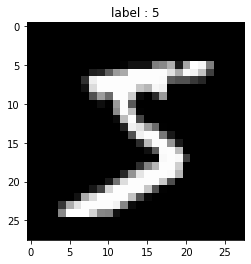

In [53]:
# 描画
index = 0
image = X_train[index]
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

In [54]:
# 2次元→1次元（画像データ→行データ）
X_train = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
X_test = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

In [55]:
# データの確認
print("訓練データ全体",X_train.shape) 
print("テストデータ全体",X_test.shape) 
print("訓練データの1つのデータ",X_train[0].shape)
print("訓練データの1つのデータの型",X_train[0].dtype) 

訓練データ全体 (60000, 784)
テストデータ全体 (10000, 784)
訓練データの1つのデータ (784,)
訓練データの1つのデータの型 uint8


In [56]:
# NNの入力値にするため、0-1に収めてやる
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) 
print(X_train.min())

1.0
0.0


In [57]:
# 訓練データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

In [58]:
# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
y_val_one_hot = enc.transform(y_val[:, np.newaxis]) # add

print("訓練データ 目的変数",y_train_one_hot.shape) 
print("テストデータ 目的変数",y_test_one_hot.shape) 
print("評価データ 目的変数",y_val_one_hot.shape)  # add

訓練データ 目的変数 (48000, 10)
テストデータ 目的変数 (12000, 10)


# ミニバッチクラス

イテレータというもので実現しますので、まずは、iterの基本動作を見ていきます。

## イテレータの基本

In [59]:
class SampleIterator:
    def __init__(self, num):
        """通常のコンストラクタと同様の働き
        """
        # 最大呼び出し回数
        self.num = num

    def __iter__(self):
        """
        呼び出される際は、まずここが呼ばれる
        return self 部分は、このインスタンス自身を返している
        """
        # 現在位置
        self.current = 0
        return self

    def __next__(self):
        """基本的にここに返してやりたい処理を書く
        """
        # 現在位置が最大呼び出し回数に達したかの判定
        if self.current == self.num:
            raise StopIteration()
        
        # 返してやりたい値
        value = self.current
        
        # 現在位置を進める
        self.current += 1
        
        return value

In [60]:
sample_iter = SampleIterator(3)
for i in sample_iter:
    print(i)

0
1
2


## ミニバッチイテレータ

NNの学習の際、このクラスを呼び出すだけで、データを生成してくれるようにする

In [61]:
class GetMiniBatch:

    def __init__(self, X, y, batch_size = 20, seed=0):
        """通常のコンストラクタと同様の働き
        Parameters
        ----------
        X : 説明変数（画像の1次元データ）
        y : 目的変数（ラベル）
        batch_size : 必要なミニバッチのデータ数
        seed : ランダムシード固定
        """
        # ランダムシードの固定（学習ごとに同じ生成順）
        np.random.seed(seed)
        # バッチ数のメンバ変数
        self.batch_size = batch_size
        # データ全体の長さ分のインデックスをランダムに並べ替え
        # np.random.permutation:配列をランダムに並べ替え
        shuffle_index = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        # 並べ替えたインデックスと同じ順番で説明変数と目的変数を並べ替え
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        # データ数をバッチ数で割って、何回呼び出せば、全データを学習したことになるかの判定
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop
    
    def __iter__(self):
        # 何回目の呼び出しか
        self._counter = 0
        return self

    def __next__(self):
        # 全データを学習すればストップ
        if self._counter >= self._stop:
            raise StopIteration()
        # 並び変えた_X,_yの何番目のインデックスを採用するか
        p0 = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        p1 = self._counter*self.batch_size + self.batch_size
        # returnする前にカウンタに+1しておく
        self._counter += 1
        # 説明変数と目的変数を返す
        return self._X[p0:p1], self._y[p0:p1]

# NNクラスの作成

In [62]:
class ScratchSimpleNeuralNetrowkClassifier():

    def __init__(self,batch_size = 20,n_features = 784,n_nodes1 = 400,n_nodes2 = 200,n_output = 10,sigma = 0.02,lr = 0.01,epoch = 10, verbose=True):
        """学習に必要なメンバ変数の初期化
        Parameters
        ----------
        verbose : 計算過程を出力するか否か
        batch_size : ミニバッチのデータ数
        n_features : 説明変数の数
        n_nodes1 : 1層目のノードの数
        n_nodes2 : 2層目のノードの数
        n_output : 出力層のノードの数
        sigma : 重みの初期化の際のガウス分布の標準偏差
        lr : 学習率
        epoch : 学習回数
        """
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2 
        self.n_output = n_output
        self.sigma = sigma
        self.lr = lr
        self.epoch = epoch
        # 損失記録用
        self.loss_train = []
        self.loss_val = [] # change
        # 使用する重みの初期化
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B1 = self.sigma * np.random.randn(1, self.n_nodes1)
        self.B2 = self.sigma * np.random.randn(1, self.n_nodes2)
        self.B3 = self.sigma * np.random.randn(1, self.n_output)
    
    def fit(self, X, y, X_val=None, y_val=None): # change
        """学習
        Parameters
        ----------
        X : 説明変数
        y : 目的変数
        X_test : 説明変数
        y_test : 目的変数
        
        Overview
        ----------
        学習回数分学習を繰り返すが、各学習の中でもミニバッチで全データ学習させている。
        イメージとしては、下記
        学習0回目
        　ミニバッチ学習0回目→ミニバッチ学習1回目→・・・
        学習1回目
        　ミニバッチ学習0回目→ミニバッチ学習1回目→・・・
        ・・・・
        """
        # 学習回数分ループ
        for _ in range(self.epoch):
            
            # 先ほど定義したミニバッチイテレータのインスタンス化
            get_mini_batch = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
            
            # ミニバッチイテレータが停止するまでバッチ学習
            # get_mini_batchを呼び出すたびに、説明変数と目的変数が返ってくる
            for mini_X_train, mini_y_train in get_mini_batch:
                # 順伝播
                self.forward(mini_X_train)
                # 逆伝播
                self.backward(mini_X_train, mini_y_train)
                
            # ミニバッチ学習後のロス計算
            self.forward(X)
            self.loss_train.append(self.cross_entropy_error(y, self.Z3))
            # 評価データがあるなら、こちらも計算
            if X_test is not None:
                self.forward(X_test)
                self.loss_test.append(self.cross_entropy_error(y_test, self.Z3))
        
        # 学習過程の出力
        if self.verbose:
            if X_val is None: # change
                print(self.loss_train)
            else:
                print(self.loss_train,self.loss_val) # change
    
    def forward(self, X):
        """順伝播
        Parameters
        ----------
        X : 説明変数
        """
        ## 1層目
        # 活性化関数に通す前
        self.A1 = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        # 上記を活性化関数に通す
        self.Z1 = self.tanh_function(self.A1)
        
        ## 2層目
        # 活性化関数に通す前
        self.A2 = self.Z1 @ self.W2 + self.B2
        # 上記を活性化関数に通す
        self.Z2 = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        
        ## 3層目（出力層）
        # 活性化関数に通す前
        self.A3 = self.Z2 @ self.W3 + self.B3
        # 上記を活性化関数に通す
        self.Z3 = XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        
        # メンバ変数self.Z3がNNの出力となる
    
    def backward(self, X, y):
        """順伝播
        Parameters
        ----------
        X : 説明変数
        """
        ## 3層目（出力層）
        # 3層目の重みに対する勾配
        dA3 = (self.Z3 - y)/self.batch_size # change
        dW3 = self.Z2.T @ dA3
        # 3層目のバイアス項に対する勾配
        dB3 = np.sum(dA3, axis=0)
        
        ## 2層目
        # 2層目の重みに対する勾配
        dZ2 = dA3 @ self.W3.T
        dA2 = dZ2 * (1 - self.tanh_function(self.A2)**2)
        dW2 = self.Z1.T @ dA2
        # 2層目のバイアス項に対する勾配
        dB2 = np.sum(dA2, axis=0)
        
        ## 1層目
        # 1層目の重みに対する勾配
        dZ1 = dA2 @ self.W2.T
        dA1 = dZ1 * (1 - self.tanh_function(self.A1)**2)
        dW1 = X.T @ dA1
        # 1層目のバイアス項に対する勾配
        dB1 = np.sum(dA1, axis=0)
        
        # 各勾配に学習率を掛けて更新
        self.W3 -= self.lr * XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        self.B3 -= self.lr * XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        self.W2 -= self.lr * XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        self.B2 -= self.lr * XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        self.W1 -= self.lr * XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
        self.B1 -= self.lr * XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
            
    def tanh_function(self, A):
        """活性化関数tanh
        Parameters
        ----------
        A : 何かしらの配列
        """
        return np.tanh(A)
    
    def softmax(self, A):
        """活性化関数softmax
        Parameters
        ----------
        A : 何かしらの配列
        """
        return np.exp(A) / np.sum(np.exp(A), axis=1).reshape(-1, 1)

    def cross_entropy_error(self, y, Z):
        """損失関数　クロスエントロピー誤差
        Parameters
        ----------
        y : 正解データ
        Z : 予測値
        """
        L = - np.sum(y * np.log(Z)) / len(y)
        return L
        
    def predict(self, X):
        """予測
        Parameters
        ----------
        X : 説明変数
        """
        # 順伝播処理
        self.forward(X)
        # 最も大きいインデックスをクラスとして採用
        return np.argmax(self.Z3, axis=1)

# 問題6

In [63]:
# インスタンス化
nn = ScratchSimpleNeuralNetrowkClassifier(epoch=10)
# 学習
nn.fit(X_train[:10000],y_train_one_hot[:10000], X_val, y_val_one_hot)  # change

[0.341270311121405, 0.2528601494399063, 0.18866239031832646, 0.13758947487464437, 0.10220658287671736, 0.07710166661142956, 0.057734508167005615, 0.04215742810501739, 0.033048330485772826, 0.025460856867148128] [0.3623812721834619, 0.30618640476496867, 0.2649515238284755, 0.232363444876015, 0.2130760586397361, 0.20212925551727257, 0.19706286196795608, 0.19319391450040282, 0.19470967662741676, 0.1981324266512743]


In [64]:
# 予測
pred_train = nn.predict(X_train)
pred_test = nn.predict(X_test)

In [65]:
# 正解率
accuracy_score(y_train, pred_train),accuracy_score(y_test, pred_test)

(0.9562916666666667, 0.94875)

# 問題7

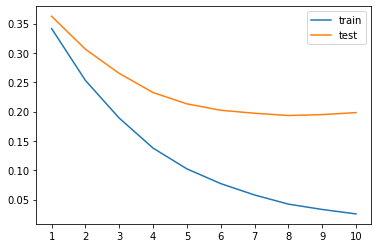

In [66]:
plt.plot(list(range(1, nn.epoch+1)), nn.loss_train, label='train')
plt.plot(list(range(1, nn.epoch+1)), nn.loss_val, label='test') # change
plt.legend()
plt.xticks(list(range(1, nn.epoch+1)));